In [2]:
import os
import pandas as pd 
import polars as pl

# import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [3]:
# Set up the plotting parameters
figformat = 'pdf'
dpi = 300
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Set up the data directories
statarg = 'single'
OutputDir = f'./4_CellCoverage'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = 'old_features3/1_FeaturesImages_meanstd_PerPlate'

In [4]:
statmet = 'SingleCell'
filenames = ['HT29', 'HCT116']
cell_line = 0 # 0 for HT29, 1 for HCT116
trt_type = 'dmso'

### TODO: 
* Import as pandas dataframe
* Calculate the totals per spheroid

In [5]:
df_single = pl.read_parquet(f'{FeatureDir}/{statmet}/{filenames[cell_line]}.parquet')

In [26]:
df = pl.DataFrame()

# Load the data for all cell lines
for i in range(0, len(filenames)):
    tmp = pl.read_parquet(f'{FeatureDir}/{statmet}/{filenames[i]}.parquet')
    print(filenames[i])
    df = df.vstack(tmp)


HT29
HCT116


In [17]:
# df.select(pl.col('Metadata_cmpd_target')).to_series().unique()

Metadata_cmpd_target
str
"""Microtubule As…"
"""p38 MAPK"""
"""E3 Ligase ,Mdm…"
"""Bcl-2,Autophag…"
"""MEK"""
…
"""EGFR,HER2"""
"""Tak1"""
"""c-RET,VEGFR"""


In [27]:
df_dmso = df.filter(pl.col('Metadata_cmpd_cmpdname')=='dmso')

In [28]:
df_dmso.head()

Cytoplasm_ImageNumber,Cytoplasm_ObjectNumber,Cytoplasm_Metadata_AcqID,Metadata_Barcode,Metadata_Site,Metadata_Well,Cytoplasm_FileName_CONC,Cytoplasm_FileName_HOECHST,Cytoplasm_FileName_MITO,Cytoplasm_FileName_PHAandWGA,Cytoplasm_FileName_SYTO,Cytoplasm_PathName_CONC,Cytoplasm_PathName_HOECHST,Cytoplasm_PathName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_BoundingBoxArea,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_ConvexArea,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_EquivalentDiameter,Cytoplasm_AreaShape_EulerNumber,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,…,Cells_RadialDistribution_ZernikePhase_SYTO_3_1,Cells_RadialDistribution_ZernikePhase_SYTO_3_3,Cells_RadialDistribution_ZernikePhase_SYTO_4_0,Cells_RadialDistribution_ZernikePhase_SYTO_4_2,Cells_RadialDistribution_ZernikePhase_SYTO_4_4,Cells_RadialDistribution_ZernikePhase_SYTO_5_1,Cells_RadialDistribution_ZernikePhase_SYTO_5_3,Cells_RadialDistribution_ZernikePhase_SYTO_5_5,Cells_RadialDistribution_ZernikePhase_SYTO_6_0,Cells_RadialDistribution_ZernikePhase_SYTO_6_2,Cells_RadialDistribution_ZernikePhase_SYTO_6_4,Cells_RadialDistribution_ZernikePhase_SYTO_6_6,Cells_RadialDistribution_ZernikePhase_SYTO_7_1,Cells_RadialDistribution_ZernikePhase_SYTO_7_3,Cells_RadialDistribution_ZernikePhase_SYTO_7_5,Cells_RadialDistribution_ZernikePhase_SYTO_7_7,Cells_RadialDistribution_ZernikePhase_SYTO_8_0,Cells_RadialDistribution_ZernikePhase_SYTO_8_2,Cells_RadialDistribution_ZernikePhase_SYTO_8_4,Cells_RadialDistribution_ZernikePhase_SYTO_8_6,Cells_RadialDistribution_ZernikePhase_SYTO_8_8,Cells_RadialDistribution_ZernikePhase_SYTO_9_1,Cells_RadialDistribution_ZernikePhase_SYTO_9_3,Cells_RadialDistribution_ZernikePhase_SYTO_9_5,Cells_RadialDistribution_ZernikePhase_SYTO_9_7,Cells_RadialDistribution_ZernikePhase_SYTO_9_9,Metadata_cmpd_image_id,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Metadata_cmpd_plate_well,Metadata_cmpd_cmpdname,Metadata_cmpd_pert_type,Metadata_cmpd_target,Metadata_cmpd_pathway,Metadata_cmpd_target_type,Metadata_cmpd_cell_line,Metadata_PlateWell
i32,i32,i32,str,i32,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,i32,f32,f32,f32,i32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i64,str,str,str,str,str,str,str,str,str
1,1,4191,"""PB000142""",0,"""N04""","""Well-N04-z0-CO…","""Well-N04-z0-HO…","""Well-N04-z0-MI…","""Well-N04-z0-PH…","""Well-N04-z0-SY…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…",3752,4891,536,337,463,270,497.640472,303.305969,1.124988,3831,0.437203,69.117256,1,0.767123,0.888898,73.145081,74.040527,32.0,11.400725,10.0,65.898445,…,2.874434,3.049932,-1.570796,-1.82453,-0.188775,2.973966,-2.869677,1.151401,-1.570796,-2.311358,0.442847,-1.354712,-0.350877,-0.421607,0.205414,1.124477,1.570796,1.151731,0.086862,-2.740131,-1.665544,0.260534,0.402003,0.857256,1.672337,0.500435,4191,5574,"""PB000142""","""PB000142_N04""","""dmso""","""neg_con""","""control""","""dmso""",null,"""HT29""","""PB000142_N04"""
1,2,4191,"""PB000142""",0,"""N04""","""Well-N04-z0-CO…","""Well-N04-z0-HO…","""Well-N04-z0-MI…","""Well-N04-z0-PH…","""Well-N04-z0-SY…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…","""/share/mikro2/…",7599,9720,688,464,580,374,634.741394,416.973541,1.152929,7756,0.554563,98.363342,1,0.78179,0.867356,108.081413,108.342049,44.28318,16.019737,14.

In [29]:
df.select(pl.col('Metadata_Site')).to_series().unique()

Metadata_Site
i32
0
1
2
3
4
…
8
9
10


In [30]:
def calc_numcells(df):
    max_columns=[pl.col('Cytoplasm_ObjectNumber'), pl.col('Nuclei_ObjectNumber')]
    sum_columns=[pl.col('Cytoplasm_AreaShape_Area')]
    mean_columns = max_columns + sum_columns
    df_out = pl.DataFrame()
    df = df.with_columns(pl.col('Cytoplasm_ObjectNumber').cast(pl.Float64))
    df_max_columns=set(list(df.select(max_columns).columns))
    df_sum_columns=set(list(df.select(sum_columns).columns))
    group_by_columns=['Metadata_PlateWell','Metadata_Site', 'Metadata_cmpd_cell_line']
    other_columns=set(list(df.columns))-df_max_columns-df_sum_columns-set(group_by_columns)
    group_by_aggregates=[
    *[pl.max(x) for x in list(df_max_columns)],
    # *[pl.std(x).alias(f"{x}_std") for x in list(df_max_columns)],
    *[pl.sum(x) for x in list(df_sum_columns)],
    *[pl.first(x) for x in list(other_columns)]
    ]
    df=df.group_by(group_by_columns).agg(group_by_aggregates)

    #didn't need this, ffs......
    # df = df.drop(['Metadata_Well', 'Metadata_PlateWell', 'Metadata_Barcode'])
    # df_mean_columns=set(list(df.select(mean_columns).columns))
    # group_by_columns=['Metadata_Site']
    # other_columns=set(list(df.columns))-df_mean_columns-set(group_by_columns)
    # group_by_aggregates=[
    # *[pl.max(x) for x in list(df_mean_columns)],
    # *[pl.std(x).alias(f"{x}_std") for x in list(df_mean_columns)],
    # *[pl.first(x) for x in list(other_columns)]
    # ]
    # df=df.group_by(group_by_columns).agg(group_by_aggregates)

    df_out = df
    return df_out

In [31]:
df2 = df_dmso.select(pl.col(['Metadata_PlateWell', 'Metadata_Well', 'Metadata_Barcode', 'Metadata_Site', 'Metadata_cmpd_cell_line', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_ObjectNumber', 'Nuclei_ObjectNumber']))

In [51]:
df2.head()

Metadata_PlateWell,Metadata_Well,Metadata_Barcode,Metadata_Site,Metadata_cmpd_cell_line,Cytoplasm_AreaShape_Area,Cytoplasm_ObjectNumber,Nuclei_ObjectNumber
str,str,str,i32,str,i32,i32,f64
"""PB000142_N04""","""N04""","""PB000142""",0,"""HT29""",3752,1,1.0
"""PB000142_N04""","""N04""","""PB000142""",0,"""HT29""",7599,2,2.0
"""PB000142_N04""","""N04""","""PB000142""",0,"""HT29""",3182,3,4.0
"""PB000142_N04""","""N04""","""PB000142""",0,"""HT29""",4399,4,5.0
"""PB000142_N04""","""N04""","""PB000142""",0,"""HT29""",3275,5,4.5


In [33]:
df3 = calc_numcells(df2)
df3 = df3.sort(pl.col('Metadata_Site'))

In [34]:
df3.head()

Metadata_PlateWell,Metadata_Site,Metadata_cmpd_cell_line,Nuclei_ObjectNumber,Cytoplasm_ObjectNumber,Cytoplasm_AreaShape_Area,Metadata_Barcode,Metadata_Well
str,i32,str,f64,f64,i32,str,str
"""PB000140_G14""",0,"""HT29""",22.5,21.0,76257,"""PB000140""","""G14"""
"""PB000142_C05""",0,"""HT29""",12.5,10.0,37705,"""PB000142""","""C05"""
"""PB000138_L07""",0,"""HCT116""",19.0,15.0,44215,"""PB000138""","""L07"""
"""PB000140_K09""",0,"""HCT116""",40.0,35.0,94331,"""PB000140""","""K09"""
"""PB000137_I21""",0,"""HCT116""",25.0,23.0,60549,"""PB000137""","""I21"""


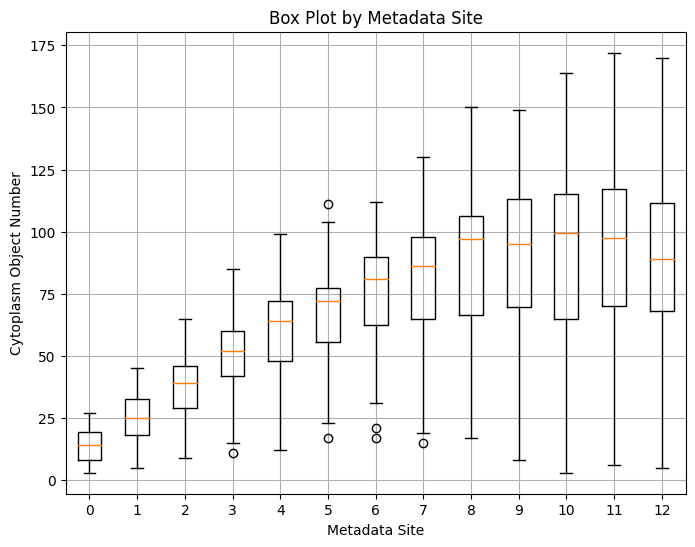

In [54]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Cytoplasm_ObjectNumber'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Cytoplasm Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()

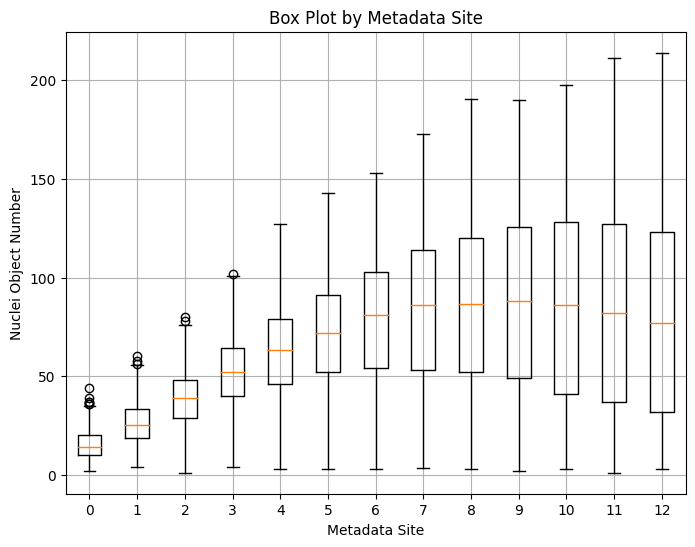

In [27]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Nuclei_ObjectNumber'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Nuclei Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()

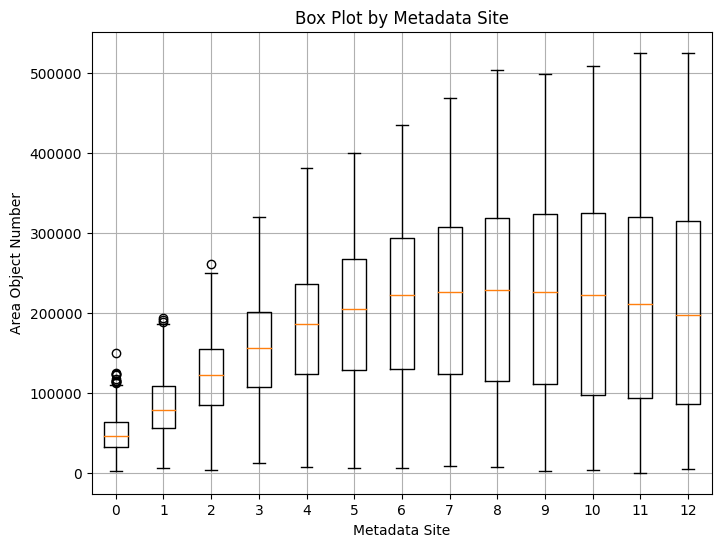

In [29]:
data = [df3.filter(pl.col('Metadata_Site') == site)['Cytoplasm_AreaShape_Area'].to_list() for site in df3['Metadata_Site'].unique()]

# Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=df3['Metadata_Site'].unique())

# Customize the plot
plt.xlabel('Metadata Site')
plt.ylabel('Area Object Number')
plt.title('Box Plot by Metadata Site')
plt.grid(True)

# Show the plot
plt.show()

In [36]:
# Polars to Pandas
data = df3.to_pandas()

# # Prepare the data to plot
# Add a Site with 

totals = data.groupby('Metadata_PlateWell').agg({'Cytoplasm_ObjectNumber': 'sum'})

totals

# data_toplot = data.query()
# [data[data['Metadata_Site'] == site]['Cytoplasm_ObjectNumber'].to_list() for site in data['Metadata_Site'].unique()]

,Cytoplasm_ObjectNumber
Metadata_PlateWell,
PB000137_B22,946.0
PB000137_C05,1949.0
PB000137_D12,1813.0
PB000137_E16,1422.0
PB000137_F06,1377.0
...,...
PB000142_L18,743.0
PB000142_M23,678.0
PB000142_N04,1007.0


(-0.4, 210.0)

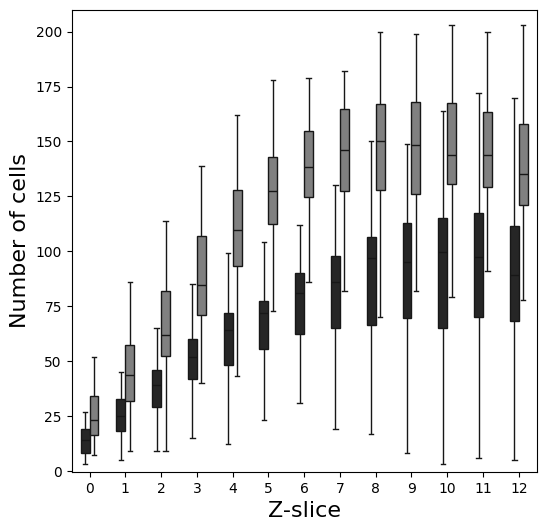

In [44]:
# Plot the data in a boxplot
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=data, x='Metadata_Site', y='Cytoplasm_ObjectNumber', width=0.5, fill=True, hue='Metadata_cmpd_cell_line',palette='dark:grey', fliersize=1, showfliers=False, legend=False)

ax.set_xlabel('Z-slice', fontsize=12)
ax.set_ylabel('Number of cells', fontsize=12)
ax.set_ylim(-0.4, 210)

plt.title('Cells Reproducibility - ' + data_type, fontsize=16)
# plt.show()

# fig.savefig(
#         "3_PercentReplicating/result-images/PercentReplicating_{}.{}".format(data_type, figformat), dpi=dpi, bbox_inches="tight"
#         )

### Estimation of total cell number

In [34]:
## Guestimate number of cells
number_of_cells = 60
pixel_area = 210000
resolution = 0.227
diameter_spheroid = 130 # in µm

# Calculate area per cell
area_per_cell = pixel_area / number_of_cells

# Calculate the diameter of a cell
diameter = 2 * np.sqrt(area_per_cell / np.pi) * resolution # in µm
print("diameter of a cell: ", diameter)

# Calculate the volume of a cell
volume = (4/3) * np.pi * (diameter/2)**3

# Calculate the volume of the spheroid
volume_spheroid = (4/3) * np.pi * (diameter_spheroid/2)**3

# Calculate the number of cells in a spheroid
number_of_cells_spheroid = volume_spheroid / volume

print("Number of cells in a spheroid: ", number_of_cells_spheroid)

diameter of a cell:  15.153569274342718
number of cells in a spheroid:  631.3718879342445
